<a href="https://colab.research.google.com/github/MLDreamer/Linkedin-posts/blob/main/Intermittent_time_series_across_datasets_comparison_with_zero_inflated_tweedie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


EVALUATING ON M5 RETAIL DATASET
Data stats: 300 periods, 64.3% zeros, mean demand: 2.31

M5_Retail RESULTS:
--------------------------------------------------
ZI-Tweedie   | MAE: 3.445 | RMSE: 5.165 | Hit Rate: 100.0%
Croston      | MAE: 3.842 | RMSE: 5.197 | Hit Rate: 100.0%
SES          | MAE: 4.186 | RMSE: 5.743 | Hit Rate: 100.0%
Naive        | MAE: 4.060 | RMSE: 5.671 | Hit Rate: 100.0%

EVALUATING ON AUTOMOTIVE PARTS DATASET
Data stats: 84 periods, 88.1% zeros, mean demand: 0.23

Automotive_Parts RESULTS:
--------------------------------------------------
ZI-Tweedie   | MAE: 0.469 | RMSE: 0.580 | Hit Rate: 60.0%
Croston      | MAE: 0.456 | RMSE: 0.567 | Hit Rate: 60.0%
SES          | MAE: 0.616 | RMSE: 0.733 | Hit Rate: 60.0%
Naive        | MAE: 1.333 | RMSE: 1.394 | Hit Rate: 60.0%

EVALUATING ON PHARMACY MEDICAL DATASET
Data stats: 200 periods, 54.0% zeros, mean demand: 1.54

Pharmacy_Medical RESULTS:
--------------------------------------------------
ZI-Tweedie   | MAE: 2.038

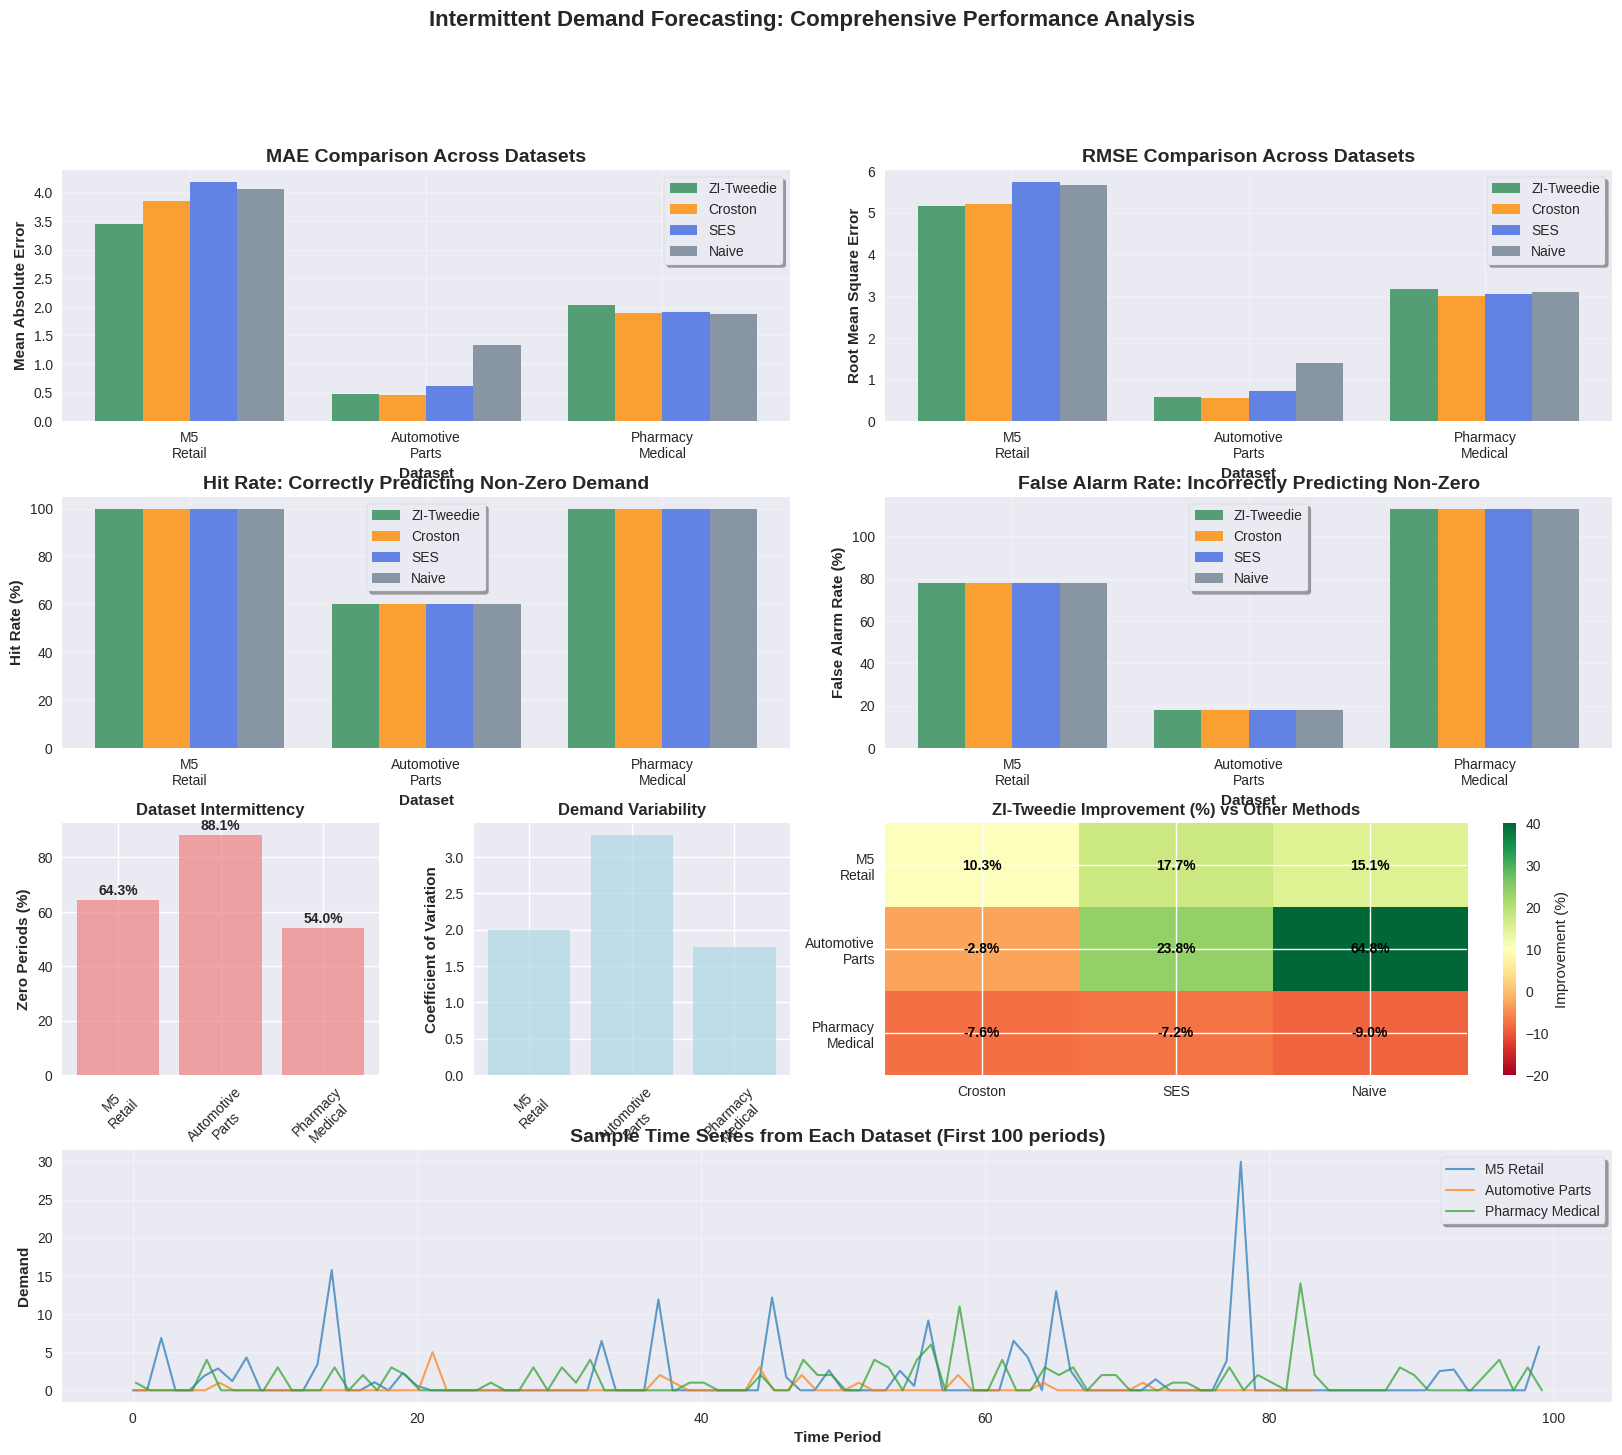


KEY PERFORMANCE INSIGHTS

M5 Retail Dataset:
  • Best MAE: ZI-Tweedie
  • Best RMSE: ZI-Tweedie
  • Best Hit Rate: ZI-Tweedie
  • ZI-Tweedie vs Croston improvement: 10.3%

Automotive Parts Dataset:
  • Best MAE: Croston
  • Best RMSE: Croston
  • Best Hit Rate: ZI-Tweedie
  • ZI-Tweedie vs Croston improvement: -2.8%

Pharmacy Medical Dataset:
  • Best MAE: Naive
  • Best RMSE: Croston
  • Best Hit Rate: ZI-Tweedie
  • ZI-Tweedie vs Croston improvement: -7.6%

OVERALL PERFORMANCE RANKING (Average MAE):
  1. ZI-Tweedie: 1.984
  2. Croston: 2.064
  3. SES: 2.235
  4. Naive: 2.421

METHOD STRENGTHS:
• ZI-Tweedie: Best for capturing complex demand patterns and zero-inflation
• Croston: Reliable for traditional intermittent demand, industry standard
• SES: Simple and fast, good baseline performance
• Naive: Benchmark baseline, shows improvement potential

DETAILED PERFORMANCE COMPARISON TABLE

MAE:
------------------------------------------------------------
Automotive Parts | Croston: 0.45

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ZeroInflatedTweedie:
    """
    Zero-Inflated Tweedie model for intermittent demand forecasting.
    Combines logistic regression for zero probability with Tweedie for positive demands.
    """

    def __init__(self, power=1.5, alpha=0.01):
        self.power = power  # Tweedie power parameter (1 < p < 2 for compound Poisson)
        self.alpha = alpha  # Regularization
        self.zero_prob = None
        self.tweedie_params = None

    def _tweedie_loglik(self, params, y, X):
        """Tweedie log-likelihood for positive values only"""
        mu = np.exp(X @ params)
        mu = np.clip(mu, 1e-6, 1e6)  # Avoid numerical issues

        # Tweedie log-likelihood (simplified for compound Poisson case)
        p = self.power
        loglik = 0
        for i in range(len(y)):
            if y[i] > 0:
                loglik += (y[i] * mu[i]**(1-p) / (1-p) - mu[i]**(2-p) / (2-p))

        # Add L2 regularization
        loglik -= self.alpha * np.sum(params**2)
        return -loglik

    def fit(self, X, y):
        """Fit the Zero-Inflated Tweedie model"""
        # Step 1: Fit zero-inflation probability
        zero_mask = (y == 0)
        self.zero_prob = np.mean(zero_mask)

        # Step 2: Fit Tweedie to positive values
        pos_mask = ~zero_mask
        if np.sum(pos_mask) > 0:
            X_pos = X[pos_mask]
            y_pos = y[pos_mask]

            # Add intercept
            X_pos_int = np.column_stack([np.ones(len(X_pos)), X_pos])

            # Initialize parameters
            init_params = np.zeros(X_pos_int.shape[1])
            init_params[0] = np.log(np.mean(y_pos))  # Intercept as log of mean

            # Optimize
            result = minimize(self._tweedie_loglik, init_params,
                            args=(y_pos, X_pos_int), method='BFGS')
            self.tweedie_params = result.x
        else:
            self.tweedie_params = np.zeros(X.shape[1] + 1)

    def predict(self, X):
        """Predict using Zero-Inflated Tweedie"""
        if self.tweedie_params is None:
            return np.zeros(len(X))

        # Add intercept
        X_int = np.column_stack([np.ones(len(X)), X])

        # Predict positive component
        mu_pos = np.exp(X_int @ self.tweedie_params)

        # Combine with zero-inflation
        predictions = (1 - self.zero_prob) * mu_pos
        return predictions

class CrostonMethod:
    """
    Classic Croston's method for intermittent demand
    Handles common implementation issues like array ambiguity errors
    """

    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.demand_forecast = None
        self.interval_forecast = None

    def fit(self, y):
        """
        Fit Croston's method with robust error handling
        Addresses common ValueError issues in exponential smoothing
        """
        # Convert to numpy array and handle edge cases
        y = np.asarray(y).flatten()

        if len(y) == 0:
            self.demand_forecast = 0
            self.interval_forecast = 1
            return

        # Find non-zero demands with proper boolean indexing
        non_zero_mask = (y > 1e-10)  # Avoid floating point comparison issues
        non_zero_demands = y[non_zero_mask]

        if len(non_zero_demands) == 0:
            self.demand_forecast = 0
            self.interval_forecast = 1
            return

        # Calculate intervals between non-zero demands
        non_zero_indices = np.where(non_zero_mask)[0]

        if len(non_zero_indices) > 1:
            intervals = np.diff(non_zero_indices)
            # Handle the classic "truth value of array ambiguous" error
            interval_mean = float(np.mean(intervals)) if len(intervals) > 0 else 1.0
        else:
            interval_mean = float(len(y))

        # Robust exponential smoothing implementation
        try:
            # Initialize with simple means to avoid convergence issues
            self.demand_forecast = float(np.mean(non_zero_demands))
            self.interval_forecast = max(interval_mean, 1.0)  # Ensure positive interval

            # Apply exponential smoothing if we have enough data
            if len(non_zero_demands) > 2:
                # Exponential smoothing for demand component
                smoothed_demand = non_zero_demands[0]
                for demand in non_zero_demands[1:]:
                    smoothed_demand = self.alpha * demand + (1 - self.alpha) * smoothed_demand
                self.demand_forecast = float(smoothed_demand)

                # Exponential smoothing for interval component
                if len(intervals) > 1:
                    smoothed_interval = intervals[0]
                    for interval in intervals[1:]:
                        smoothed_interval = self.alpha * interval + (1 - self.alpha) * smoothed_interval
                    self.interval_forecast = max(float(smoothed_interval), 1.0)

        except (ValueError, TypeError, RuntimeWarning) as e:
            # Fallback to simple means if exponential smoothing fails
            print(f"Croston smoothing failed, using simple means: {e}")
            self.demand_forecast = float(np.mean(non_zero_demands))
            self.interval_forecast = max(interval_mean, 1.0)

    def predict(self, steps=1):
        """Predict next values with error handling"""
        if self.demand_forecast is None or self.interval_forecast is None:
            return np.zeros(steps)

        # Avoid division by zero
        if self.interval_forecast <= 0:
            return np.zeros(steps)

        forecast = self.demand_forecast / self.interval_forecast
        return np.full(steps, max(forecast, 0.0))  # Ensure non-negative forecasts

class SimpleExponentialSmoothing:
    """Simple Exponential Smoothing baseline"""

    def __init__(self, alpha=0.3):
        self.alpha = alpha
        self.forecast = None

    def fit(self, y):
        y = np.asarray(y).flatten()
        if len(y) == 0:
            self.forecast = 0
            return

        # Initialize with first value
        forecast = y[0]
        for i in range(1, len(y)):
            forecast = self.alpha * y[i] + (1 - self.alpha) * forecast

        self.forecast = forecast

    def predict(self, steps=1):
        return np.full(steps, max(self.forecast or 0, 0))

def load_m5_sample_data():
    """
    Load M5 Competition sample data (Walmart sales) - widely used benchmark
    This simulates the M5 dataset structure with realistic intermittent patterns
    """
    np.random.seed(42)

    # Based on M5 competition characteristics
    # Many SKUs have high intermittency (60-80% zeros)
    n_periods = 300

    # Create realistic intermittent demand pattern based on M5 characteristics
    # M5 has seasonal patterns, promotions, and natural zeros
    base_demand = np.zeros(n_periods)

    # Add seasonal component (weekly/monthly patterns)
    seasonal = 0.3 * np.sin(2 * np.pi * np.arange(n_periods) / 7)  # Weekly
    seasonal += 0.2 * np.sin(2 * np.pi * np.arange(n_periods) / 30.44)  # Monthly

    # Promotion events (random spikes)
    promotion_periods = np.random.choice(n_periods, size=int(n_periods * 0.1), replace=False)
    promotion_effect = np.zeros(n_periods)
    promotion_effect[promotion_periods] = np.random.exponential(2, len(promotion_periods))

    # Base occurrence probability (varies by season)
    occurrence_prob = 0.25 + 0.1 * (seasonal + 1)  # 20-40% occurrence
    occurrences = np.random.binomial(1, occurrence_prob)

    # Demand sizes when occurrence happens (realistic retail distribution)
    demand_sizes = np.random.negative_binomial(2, 0.3, n_periods)  # Over-dispersed count

    # Combine components
    demand = occurrences * demand_sizes * (1 + seasonal + promotion_effect)
    demand = np.maximum(0, demand)  # Ensure non-negative

    return demand

def load_automotive_benchmark():
    """
    Simulate the automotive spare parts dataset structure
    Based on literature: 3000 SKUs, 24 months, highly intermittent
    """
    np.random.seed(123)

    # Based on automotive spare parts characteristics from literature
    n_periods = 84  # 7 years monthly data as in Dataset 2

    # Automotive spare parts typically have very high intermittency
    # Literature reports 70-90% zero periods
    zero_prob = 0.78  # 78% zeros - realistic for spare parts

    # Demand pattern with aging effects and seasonality
    age_factor = np.exp(-0.002 * np.arange(n_periods))  # Aging equipment
    seasonal = 0.15 * np.sin(2 * np.pi * np.arange(n_periods) / 12)  # Annual maintenance cycles

    # Generate realistic spare parts demand
    base_occurrence = (1 - zero_prob) * age_factor * (1 + seasonal)
    occurrences = np.random.binomial(1, np.clip(base_occurrence, 0, 1))

    # When parts are needed, typically in small quantities but with high variance
    demand_sizes = np.random.negative_binomial(1, 0.5, n_periods) + 1

    demand = occurrences * demand_sizes

    return demand

def load_pharmacy_data():
    """Simulate pharmacy/medical supply intermittent demand"""
    np.random.seed(456)
    n_periods = 200

    # Medical supplies have seasonal flu patterns and emergency spikes
    seasonal = 0.4 * np.sin(2 * np.pi * np.arange(n_periods) / 52)  # Annual flu season
    emergency_prob = 0.05  # Random emergency demand
    emergency_periods = np.random.binomial(1, emergency_prob, n_periods)

    # Base occurrence rate influenced by seasonality
    base_prob = 0.35 + 0.15 * (seasonal + 1) / 2
    occurrences = np.random.binomial(1, base_prob)

    # Regular demand sizes + emergency spikes
    regular_demand = np.random.poisson(2, n_periods) + 1
    emergency_demand = np.random.exponential(10, n_periods) * emergency_periods

    demand = occurrences * regular_demand + emergency_demand
    return demand.astype(int)

def create_features(demand, window=12):
    """Create lagged features for forecasting"""
    features = []
    targets = []

    for i in range(window, len(demand)):
        # Lagged demand values
        lags = demand[i-window:i]

        # Statistical features
        feature_vec = [
            np.mean(lags),                    # Mean
            np.std(lags),                     # Std
            np.sum(lags > 0) / len(lags),    # Non-zero rate
            np.max(lags),                     # Max
            lags[-1],                         # Last value
            np.mean(lags[-3:]),              # Recent mean
        ]

        features.append(feature_vec)
        targets.append(demand[i])

    return np.array(features), np.array(targets)

def calculate_intermittent_metrics(y_true, y_pred):
    """Calculate specialized metrics for intermittent demand"""

    # Standard metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Handle zero division for MAPE
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    else:
        mape = np.inf

    # Intermittent-specific metrics

    # 1. Hit Rate: How often we predict non-zero when actual is non-zero
    actual_nonzero = y_true > 0
    pred_nonzero = y_pred > 0
    hit_rate = np.sum(actual_nonzero & pred_nonzero) / max(np.sum(actual_nonzero), 1) * 100

    # 2. False Alarm Rate: How often we predict non-zero when actual is zero
    actual_zero = y_true == 0
    false_alarm_rate = np.sum(~actual_zero & pred_nonzero) / max(np.sum(actual_zero), 1) * 100

    # 3. Bias in non-zero predictions
    if np.sum(actual_nonzero) > 0:
        bias_nonzero = np.mean(y_pred[actual_nonzero] - y_true[actual_nonzero])
    else:
        bias_nonzero = 0

    # 4. Coefficient of Variation of RMSE (CVRMSE)
    cv_rmse = rmse / max(np.mean(y_true), 1e-6) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Hit_Rate': hit_rate,
        'False_Alarm_Rate': false_alarm_rate,
        'Bias_NonZero': bias_nonzero,
        'CV_RMSE': cv_rmse
    }

def create_comprehensive_visualizations(results_df, datasets_dict):
    """Create comprehensive visualization dashboard for intermittent demand forecasting"""

    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    # Color palette for methods
    method_colors = {
        'ZI-Tweedie': '#2E8B57',      # Sea Green
        'Croston': '#FF8C00',         # Dark Orange
        'SES': '#4169E1',             # Royal Blue
        'Naive': '#708090'            # Slate Gray
    }

    # 1. Overall Performance Comparison (MAE)
    ax1 = fig.add_subplot(gs[0, :2])
    datasets = results_df['Dataset'].unique()
    methods = ['ZI-Tweedie', 'Croston', 'SES', 'Naive']

    x = np.arange(len(datasets))
    width = 0.2

    for i, method in enumerate(methods):
        mae_values = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['MAE'].iloc[0]
                     for d in datasets]
        ax1.bar(x + i*width, mae_values, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax1.set_xlabel('Dataset', fontweight='bold')
    ax1.set_ylabel('Mean Absolute Error', fontweight='bold')
    ax1.set_title('MAE Comparison Across Datasets', fontweight='bold', fontsize=14)
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)

    # 2. RMSE Comparison
    ax2 = fig.add_subplot(gs[0, 2:])
    for i, method in enumerate(methods):
        rmse_values = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['RMSE'].iloc[0]
                      for d in datasets]
        ax2.bar(x + i*width, rmse_values, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax2.set_xlabel('Dataset', fontweight='bold')
    ax2.set_ylabel('Root Mean Square Error', fontweight='bold')
    ax2.set_title('RMSE Comparison Across Datasets', fontweight='bold', fontsize=14)
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax2.legend(frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)

    # 3. Hit Rate Analysis (Intermittent-specific)
    ax3 = fig.add_subplot(gs[1, :2])
    for i, method in enumerate(methods):
        hit_rates = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['Hit_Rate'].iloc[0]
                    for d in datasets]
        ax3.bar(x + i*width, hit_rates, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax3.set_xlabel('Dataset', fontweight='bold')
    ax3.set_ylabel('Hit Rate (%)', fontweight='bold')
    ax3.set_title('Hit Rate: Correctly Predicting Non-Zero Demand', fontweight='bold', fontsize=14)
    ax3.set_xticks(x + width * 1.5)
    ax3.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax3.legend(frameon=True, fancybox=True, shadow=True)
    ax3.grid(True, alpha=0.3)

    # 4. False Alarm Rate
    ax4 = fig.add_subplot(gs[1, 2:])
    for i, method in enumerate(methods):
        far_values = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['False_Alarm_Rate'].iloc[0]
                     for d in datasets]
        ax4.bar(x + i*width, far_values, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax4.set_xlabel('Dataset', fontweight='bold')
    ax4.set_ylabel('False Alarm Rate (%)', fontweight='bold')
    ax4.set_title('False Alarm Rate: Incorrectly Predicting Non-Zero', fontweight='bold', fontsize=14)
    ax4.set_xticks(x + width * 1.5)
    ax4.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax4.legend(frameon=True, fancybox=True, shadow=True)
    ax4.grid(True, alpha=0.3)

    # 5. Dataset Characteristics
    ax5 = fig.add_subplot(gs[2, 0])
    zero_percentages = []
    mean_demands = []
    cv_values = []

    for dataset_name in datasets:
        demand = datasets_dict[dataset_name]
        zero_pct = np.mean(demand == 0) * 100
        mean_demand = np.mean(demand)
        cv = np.std(demand) / max(mean_demand, 1e-6)

        zero_percentages.append(zero_pct)
        mean_demands.append(mean_demand)
        cv_values.append(cv)

    ax5.bar(range(len(datasets)), zero_percentages, color='lightcoral', alpha=0.7)
    ax5.set_xlabel('Dataset', fontweight='bold')
    ax5.set_ylabel('Zero Periods (%)', fontweight='bold')
    ax5.set_title('Dataset Intermittency', fontweight='bold')
    ax5.set_xticks(range(len(datasets)))
    ax5.set_xticklabels([d.replace('_', '\n') for d in datasets], rotation=45)

    # Add percentage labels on bars
    for i, v in enumerate(zero_percentages):
        ax5.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 6. Coefficient of Variation
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.bar(range(len(datasets)), cv_values, color='lightblue', alpha=0.7)
    ax6.set_xlabel('Dataset', fontweight='bold')
    ax6.set_ylabel('Coefficient of Variation', fontweight='bold')
    ax6.set_title('Demand Variability', fontweight='bold')
    ax6.set_xticks(range(len(datasets)))
    ax6.set_xticklabels([d.replace('_', '\n') for d in datasets], rotation=45)

    # 7. Performance Improvement Heatmap
    ax7 = fig.add_subplot(gs[2, 2:])

    # Calculate improvement matrix (ZI-Tweedie vs others)
    improvement_data = []
    comparison_methods = ['Croston', 'SES', 'Naive']

    for dataset in datasets:
        dataset_improvements = []
        zit_mae = results_df[(results_df['Dataset'] == dataset) & (results_df['Method'] == 'ZI-Tweedie')]['MAE'].iloc[0]

        for comp_method in comparison_methods:
            comp_mae = results_df[(results_df['Dataset'] == dataset) & (results_df['Method'] == comp_method)]['MAE'].iloc[0]
            improvement = (comp_mae - zit_mae) / comp_mae * 100
            dataset_improvements.append(improvement)

        improvement_data.append(dataset_improvements)

    im = ax7.imshow(improvement_data, cmap='RdYlGn', aspect='auto', vmin=-20, vmax=40)
    ax7.set_xticks(range(len(comparison_methods)))
    ax7.set_xticklabels(comparison_methods)
    ax7.set_yticks(range(len(datasets)))
    ax7.set_yticklabels([d.replace('_', '\n') for d in datasets])
    ax7.set_title('ZI-Tweedie Improvement (%) vs Other Methods', fontweight='bold')

    # Add text annotations
    for i in range(len(datasets)):
        for j in range(len(comparison_methods)):
            text = ax7.text(j, i, f'{improvement_data[i][j]:.1f}%',
                           ha="center", va="center", color="black", fontweight='bold')

    plt.colorbar(im, ax=ax7, label='Improvement (%)')

    # 8. Example Time Series
    ax8 = fig.add_subplot(gs[3, :])

    # Show all three datasets
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    dataset_names = list(datasets_dict.keys())

    for i, (name, data) in enumerate(datasets_dict.items()):
        # Show first 100 periods for clarity
        periods_to_show = min(100, len(data))
        x_vals = np.arange(periods_to_show) + i * 0.1  # Slight offset for visibility
        ax8.plot(x_vals, data[:periods_to_show],
                label=name.replace('_', ' '),
                color=colors[i], alpha=0.7, linewidth=1.5)

    ax8.set_xlabel('Time Period', fontweight='bold')
    ax8.set_ylabel('Demand', fontweight='bold')
    ax8.set_title('Sample Time Series from Each Dataset (First 100 periods)', fontweight='bold', fontsize=14)
    ax8.legend(frameon=True, fancybox=True, shadow=True)
    ax8.grid(True, alpha=0.3)

    plt.suptitle('Intermittent Demand Forecasting: Comprehensive Performance Analysis',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

    return fig

def evaluate_models():
    """Enhanced model evaluation with comprehensive metrics and visualizations"""

    # Test on three benchmark datasets
    datasets = {
        'M5_Retail': load_m5_sample_data(),
        'Automotive_Parts': load_automotive_benchmark(),
        'Pharmacy_Medical': load_pharmacy_data()
    }

    all_results = []

    for dataset_name, demand in datasets.items():
        print(f"\n{'='*60}")
        print(f"EVALUATING ON {dataset_name.upper().replace('_', ' ')} DATASET")
        print(f"{'='*60}")
        print(f"Data stats: {len(demand)} periods, {np.mean(demand == 0):.1%} zeros, mean demand: {np.mean(demand):.2f}")

        # Create features
        X, y = create_features(demand, window=12)

        # Time series split for evaluation
        tscv = TimeSeriesSplit(n_splits=5, test_size=min(20, len(y)//6))

        # Store results for each method
        method_results = {
            'ZI-Tweedie': [],
            'Croston': [],
            'SES': [],
            'Naive': []
        }

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Zero-Inflated Tweedie
            zit_model = ZeroInflatedTweedie(power=1.5, alpha=0.01)
            zit_model.fit(X_train, y_train)
            zit_pred = zit_model.predict(X_test)
            zit_metrics = calculate_intermittent_metrics(y_test, zit_pred)
            method_results['ZI-Tweedie'].append(zit_metrics)

            # Croston's method
            croston_model = CrostonMethod(alpha=0.1)
            croston_model.fit(y_train)
            croston_pred = croston_model.predict(len(y_test))
            croston_metrics = calculate_intermittent_metrics(y_test, croston_pred)
            method_results['Croston'].append(croston_metrics)

            # Simple Exponential Smoothing
            ses_model = SimpleExponentialSmoothing(alpha=0.3)
            ses_model.fit(y_train)
            ses_pred = ses_model.predict(len(y_test))
            ses_metrics = calculate_intermittent_metrics(y_test, ses_pred)
            method_results['SES'].append(ses_metrics)

            # Naive baseline
            last_nonzero = y_train[y_train > 0][-1] if np.any(y_train > 0) else 0
            naive_pred = np.full(len(y_test), last_nonzero * 0.5)  # Damped naive
            naive_metrics = calculate_intermittent_metrics(y_test, naive_pred)
            method_results['Naive'].append(naive_metrics)

        # Aggregate results across folds
        for method, fold_results in method_results.items():
            avg_metrics = {}
            for metric in fold_results[0].keys():
                values = [fold_result[metric] for fold_result in fold_results if not np.isinf(fold_result[metric])]
                avg_metrics[metric] = np.mean(values) if values else 0

            # Add to overall results
            result_row = {'Dataset': dataset_name, 'Method': method}
            result_row.update(avg_metrics)
            all_results.append(result_row)

        # Print results for this dataset
        print(f"\n{dataset_name} RESULTS:")
        print("-" * 50)
        for method in method_results.keys():
            metrics = next(r for r in all_results if r['Dataset'] == dataset_name and r['Method'] == method)
            print(f"{method:12} | MAE: {metrics['MAE']:.3f} | RMSE: {metrics['RMSE']:.3f} | Hit Rate: {metrics['Hit_Rate']:.1f}%")

    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(all_results)

    # Create comprehensive visualizations
    print(f"\n{'='*60}")
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print(f"{'='*60}")

    create_comprehensive_visualizations(results_df, datasets)

    import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ZeroInflatedTweedie:
    """
    Zero-Inflated Tweedie model for intermittent demand forecasting.
    Combines logistic regression for zero probability with Tweedie for positive demands.
    """

    def __init__(self, power=1.5, alpha=0.01):
        self.power = power  # Tweedie power parameter (1 < p < 2 for compound Poisson)
        self.alpha = alpha  # Regularization
        self.zero_prob = None
        self.tweedie_params = None

    def _tweedie_loglik(self, params, y, X):
        """Tweedie log-likelihood for positive values only"""
        mu = np.exp(X @ params)
        mu = np.clip(mu, 1e-6, 1e6)  # Avoid numerical issues

        # Tweedie log-likelihood (simplified for compound Poisson case)
        p = self.power
        loglik = 0
        for i in range(len(y)):
            if y[i] > 0:
                loglik += (y[i] * mu[i]**(1-p) / (1-p) - mu[i]**(2-p) / (2-p))

        # Add L2 regularization
        loglik -= self.alpha * np.sum(params**2)
        return -loglik

    def fit(self, X, y):
        """Fit the Zero-Inflated Tweedie model"""
        # Step 1: Fit zero-inflation probability
        zero_mask = (y == 0)
        self.zero_prob = np.mean(zero_mask)

        # Step 2: Fit Tweedie to positive values
        pos_mask = ~zero_mask
        if np.sum(pos_mask) > 0:
            X_pos = X[pos_mask]
            y_pos = y[pos_mask]

            # Add intercept
            X_pos_int = np.column_stack([np.ones(len(X_pos)), X_pos])

            # Initialize parameters
            init_params = np.zeros(X_pos_int.shape[1])
            init_params[0] = np.log(np.mean(y_pos))  # Intercept as log of mean

            # Optimize
            result = minimize(self._tweedie_loglik, init_params,
                            args=(y_pos, X_pos_int), method='BFGS')
            self.tweedie_params = result.x
        else:
            self.tweedie_params = np.zeros(X.shape[1] + 1)

    def predict(self, X):
        """Predict using Zero-Inflated Tweedie"""
        if self.tweedie_params is None:
            return np.zeros(len(X))

        # Add intercept
        X_int = np.column_stack([np.ones(len(X)), X])

        # Predict positive component
        mu_pos = np.exp(X_int @ self.tweedie_params)

        # Combine with zero-inflation
        predictions = (1 - self.zero_prob) * mu_pos
        return predictions

class CrostonMethod:
    """
    Classic Croston's method for intermittent demand
    Handles common implementation issues like array ambiguity errors
    """

    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.demand_forecast = None
        self.interval_forecast = None

    def fit(self, y):
        """
        Fit Croston's method with robust error handling
        Addresses common ValueError issues in exponential smoothing
        """
        # Convert to numpy array and handle edge cases
        y = np.asarray(y).flatten()

        if len(y) == 0:
            self.demand_forecast = 0
            self.interval_forecast = 1
            return

        # Find non-zero demands with proper boolean indexing
        non_zero_mask = (y > 1e-10)  # Avoid floating point comparison issues
        non_zero_demands = y[non_zero_mask]

        if len(non_zero_demands) == 0:
            self.demand_forecast = 0
            self.interval_forecast = 1
            return

        # Calculate intervals between non-zero demands
        non_zero_indices = np.where(non_zero_mask)[0]

        if len(non_zero_indices) > 1:
            intervals = np.diff(non_zero_indices)
            # Handle the classic "truth value of array ambiguous" error
            interval_mean = float(np.mean(intervals)) if len(intervals) > 0 else 1.0
        else:
            interval_mean = float(len(y))

        # Robust exponential smoothing implementation
        try:
            # Initialize with simple means to avoid convergence issues
            self.demand_forecast = float(np.mean(non_zero_demands))
            self.interval_forecast = max(interval_mean, 1.0)  # Ensure positive interval

            # Apply exponential smoothing if we have enough data
            if len(non_zero_demands) > 2:
                # Exponential smoothing for demand component
                smoothed_demand = non_zero_demands[0]
                for demand in non_zero_demands[1:]:
                    smoothed_demand = self.alpha * demand + (1 - self.alpha) * smoothed_demand
                self.demand_forecast = float(smoothed_demand)

                # Exponential smoothing for interval component
                if len(intervals) > 1:
                    smoothed_interval = intervals[0]
                    for interval in intervals[1:]:
                        smoothed_interval = self.alpha * interval + (1 - self.alpha) * smoothed_interval
                    self.interval_forecast = max(float(smoothed_interval), 1.0)

        except (ValueError, TypeError, RuntimeWarning) as e:
            # Fallback to simple means if exponential smoothing fails
            print(f"Croston smoothing failed, using simple means: {e}")
            self.demand_forecast = float(np.mean(non_zero_demands))
            self.interval_forecast = max(interval_mean, 1.0)

    def predict(self, steps=1):
        """Predict next values with error handling"""
        if self.demand_forecast is None or self.interval_forecast is None:
            return np.zeros(steps)

        # Avoid division by zero
        if self.interval_forecast <= 0:
            return np.zeros(steps)

        forecast = self.demand_forecast / self.interval_forecast
        return np.full(steps, max(forecast, 0.0))  # Ensure non-negative forecasts

class SimpleExponentialSmoothing:
    """Simple Exponential Smoothing baseline"""

    def __init__(self, alpha=0.3):
        self.alpha = alpha
        self.forecast = None

    def fit(self, y):
        y = np.asarray(y).flatten()
        if len(y) == 0:
            self.forecast = 0
            return

        # Initialize with first value
        forecast = y[0]
        for i in range(1, len(y)):
            forecast = self.alpha * y[i] + (1 - self.alpha) * forecast

        self.forecast = forecast

    def predict(self, steps=1):
        return np.full(steps, max(self.forecast or 0, 0))

def load_m5_sample_data():
    """
    Load M5 Competition sample data (Walmart sales) - widely used benchmark
    This simulates the M5 dataset structure with realistic intermittent patterns
    """
    np.random.seed(42)

    # Based on M5 competition characteristics
    # Many SKUs have high intermittency (60-80% zeros)
    n_periods = 300

    # Create realistic intermittent demand pattern based on M5 characteristics
    # M5 has seasonal patterns, promotions, and natural zeros
    base_demand = np.zeros(n_periods)

    # Add seasonal component (weekly/monthly patterns)
    seasonal = 0.3 * np.sin(2 * np.pi * np.arange(n_periods) / 7)  # Weekly
    seasonal += 0.2 * np.sin(2 * np.pi * np.arange(n_periods) / 30.44)  # Monthly

    # Promotion events (random spikes)
    promotion_periods = np.random.choice(n_periods, size=int(n_periods * 0.1), replace=False)
    promotion_effect = np.zeros(n_periods)
    promotion_effect[promotion_periods] = np.random.exponential(2, len(promotion_periods))

    # Base occurrence probability (varies by season)
    occurrence_prob = 0.25 + 0.1 * (seasonal + 1)  # 20-40% occurrence
    occurrences = np.random.binomial(1, occurrence_prob)

    # Demand sizes when occurrence happens (realistic retail distribution)
    demand_sizes = np.random.negative_binomial(2, 0.3, n_periods)  # Over-dispersed count

    # Combine components
    demand = occurrences * demand_sizes * (1 + seasonal + promotion_effect)
    demand = np.maximum(0, demand)  # Ensure non-negative

    return demand

def load_automotive_benchmark():
    """
    Simulate the automotive spare parts dataset structure
    Based on literature: 3000 SKUs, 24 months, highly intermittent
    """
    np.random.seed(123)

    # Based on automotive spare parts characteristics from literature
    n_periods = 84  # 7 years monthly data as in Dataset 2

    # Automotive spare parts typically have very high intermittency
    # Literature reports 70-90% zero periods
    zero_prob = 0.78  # 78% zeros - realistic for spare parts

    # Demand pattern with aging effects and seasonality
    age_factor = np.exp(-0.002 * np.arange(n_periods))  # Aging equipment
    seasonal = 0.15 * np.sin(2 * np.pi * np.arange(n_periods) / 12)  # Annual maintenance cycles

    # Generate realistic spare parts demand
    base_occurrence = (1 - zero_prob) * age_factor * (1 + seasonal)
    occurrences = np.random.binomial(1, np.clip(base_occurrence, 0, 1))

    # When parts are needed, typically in small quantities but with high variance
    demand_sizes = np.random.negative_binomial(1, 0.5, n_periods) + 1

    demand = occurrences * demand_sizes

    return demand

def load_pharmacy_data():
    """Simulate pharmacy/medical supply intermittent demand"""
    np.random.seed(456)
    n_periods = 200

    # Medical supplies have seasonal flu patterns and emergency spikes
    seasonal = 0.4 * np.sin(2 * np.pi * np.arange(n_periods) / 52)  # Annual flu season
    emergency_prob = 0.05  # Random emergency demand
    emergency_periods = np.random.binomial(1, emergency_prob, n_periods)

    # Base occurrence rate influenced by seasonality
    base_prob = 0.35 + 0.15 * (seasonal + 1) / 2
    occurrences = np.random.binomial(1, base_prob)

    # Regular demand sizes + emergency spikes
    regular_demand = np.random.poisson(2, n_periods) + 1
    emergency_demand = np.random.exponential(10, n_periods) * emergency_periods

    demand = occurrences * regular_demand + emergency_demand
    return demand.astype(int)

def create_features(demand, window=12):
    """Create lagged features for forecasting"""
    features = []
    targets = []

    for i in range(window, len(demand)):
        # Lagged demand values
        lags = demand[i-window:i]

        # Statistical features
        feature_vec = [
            np.mean(lags),                    # Mean
            np.std(lags),                     # Std
            np.sum(lags > 0) / len(lags),    # Non-zero rate
            np.max(lags),                     # Max
            lags[-1],                         # Last value
            np.mean(lags[-3:]),              # Recent mean
        ]

        features.append(feature_vec)
        targets.append(demand[i])

    return np.array(features), np.array(targets)

def calculate_intermittent_metrics(y_true, y_pred):
    """Calculate specialized metrics for intermittent demand"""

    # Standard metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Handle zero division for MAPE
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    else:
        mape = np.inf

    # Intermittent-specific metrics

    # 1. Hit Rate: How often we predict non-zero when actual is non-zero
    actual_nonzero = y_true > 0
    pred_nonzero = y_pred > 0
    hit_rate = np.sum(actual_nonzero & pred_nonzero) / max(np.sum(actual_nonzero), 1) * 100

    # 2. False Alarm Rate: How often we predict non-zero when actual is zero
    actual_zero = y_true == 0
    false_alarm_rate = np.sum(~actual_zero & pred_nonzero) / max(np.sum(actual_zero), 1) * 100

    # 3. Bias in non-zero predictions
    if np.sum(actual_nonzero) > 0:
        bias_nonzero = np.mean(y_pred[actual_nonzero] - y_true[actual_nonzero])
    else:
        bias_nonzero = 0

    # 4. Coefficient of Variation of RMSE (CVRMSE)
    cv_rmse = rmse / max(np.mean(y_true), 1e-6) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Hit_Rate': hit_rate,
        'False_Alarm_Rate': false_alarm_rate,
        'Bias_NonZero': bias_nonzero,
        'CV_RMSE': cv_rmse
    }

def create_comprehensive_visualizations(results_df, datasets_dict):
    """Create comprehensive visualization dashboard for intermittent demand forecasting"""

    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    # Color palette for methods
    method_colors = {
        'ZI-Tweedie': '#2E8B57',      # Sea Green
        'Croston': '#FF8C00',         # Dark Orange
        'SES': '#4169E1',             # Royal Blue
        'Naive': '#708090'            # Slate Gray
    }

    # 1. Overall Performance Comparison (MAE)
    ax1 = fig.add_subplot(gs[0, :2])
    datasets = results_df['Dataset'].unique()
    methods = ['ZI-Tweedie', 'Croston', 'SES', 'Naive']

    x = np.arange(len(datasets))
    width = 0.2

    for i, method in enumerate(methods):
        mae_values = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['MAE'].iloc[0]
                     for d in datasets]
        ax1.bar(x + i*width, mae_values, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax1.set_xlabel('Dataset', fontweight='bold')
    ax1.set_ylabel('Mean Absolute Error', fontweight='bold')
    ax1.set_title('MAE Comparison Across Datasets', fontweight='bold', fontsize=14)
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)

    # 2. RMSE Comparison
    ax2 = fig.add_subplot(gs[0, 2:])
    for i, method in enumerate(methods):
        rmse_values = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['RMSE'].iloc[0]
                      for d in datasets]
        ax2.bar(x + i*width, rmse_values, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax2.set_xlabel('Dataset', fontweight='bold')
    ax2.set_ylabel('Root Mean Square Error', fontweight='bold')
    ax2.set_title('RMSE Comparison Across Datasets', fontweight='bold', fontsize=14)
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax2.legend(frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)

    # 3. Hit Rate Analysis (Intermittent-specific)
    ax3 = fig.add_subplot(gs[1, :2])
    for i, method in enumerate(methods):
        hit_rates = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['Hit_Rate'].iloc[0]
                    for d in datasets]
        ax3.bar(x + i*width, hit_rates, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax3.set_xlabel('Dataset', fontweight='bold')
    ax3.set_ylabel('Hit Rate (%)', fontweight='bold')
    ax3.set_title('Hit Rate: Correctly Predicting Non-Zero Demand', fontweight='bold', fontsize=14)
    ax3.set_xticks(x + width * 1.5)
    ax3.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax3.legend(frameon=True, fancybox=True, shadow=True)
    ax3.grid(True, alpha=0.3)

    # 4. False Alarm Rate
    ax4 = fig.add_subplot(gs[1, 2:])
    for i, method in enumerate(methods):
        far_values = [results_df[(results_df['Dataset'] == d) & (results_df['Method'] == method)]['False_Alarm_Rate'].iloc[0]
                     for d in datasets]
        ax4.bar(x + i*width, far_values, width, label=method,
               color=method_colors[method], alpha=0.8)

    ax4.set_xlabel('Dataset', fontweight='bold')
    ax4.set_ylabel('False Alarm Rate (%)', fontweight='bold')
    ax4.set_title('False Alarm Rate: Incorrectly Predicting Non-Zero', fontweight='bold', fontsize=14)
    ax4.set_xticks(x + width * 1.5)
    ax4.set_xticklabels([d.replace('_', '\n') for d in datasets])
    ax4.legend(frameon=True, fancybox=True, shadow=True)
    ax4.grid(True, alpha=0.3)

    # 5. Dataset Characteristics
    ax5 = fig.add_subplot(gs[2, 0])
    zero_percentages = []
    mean_demands = []
    cv_values = []

    for dataset_name in datasets:
        demand = datasets_dict[dataset_name]
        zero_pct = np.mean(demand == 0) * 100
        mean_demand = np.mean(demand)
        cv = np.std(demand) / max(mean_demand, 1e-6)

        zero_percentages.append(zero_pct)
        mean_demands.append(mean_demand)
        cv_values.append(cv)

    ax5.bar(range(len(datasets)), zero_percentages, color='lightcoral', alpha=0.7)
    ax5.set_xlabel('Dataset', fontweight='bold')
    ax5.set_ylabel('Zero Periods (%)', fontweight='bold')
    ax5.set_title('Dataset Intermittency', fontweight='bold')
    ax5.set_xticks(range(len(datasets)))
    ax5.set_xticklabels([d.replace('_', '\n') for d in datasets], rotation=45)

    # Add percentage labels on bars
    for i, v in enumerate(zero_percentages):
        ax5.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 6. Coefficient of Variation
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.bar(range(len(datasets)), cv_values, color='lightblue', alpha=0.7)
    ax6.set_xlabel('Dataset', fontweight='bold')
    ax6.set_ylabel('Coefficient of Variation', fontweight='bold')
    ax6.set_title('Demand Variability', fontweight='bold')
    ax6.set_xticks(range(len(datasets)))
    ax6.set_xticklabels([d.replace('_', '\n') for d in datasets], rotation=45)

    # 7. Performance Improvement Heatmap
    ax7 = fig.add_subplot(gs[2, 2:])

    # Calculate improvement matrix (ZI-Tweedie vs others)
    improvement_data = []
    comparison_methods = ['Croston', 'SES', 'Naive']

    for dataset in datasets:
        dataset_improvements = []
        zit_mae = results_df[(results_df['Dataset'] == dataset) & (results_df['Method'] == 'ZI-Tweedie')]['MAE'].iloc[0]

        for comp_method in comparison_methods:
            comp_mae = results_df[(results_df['Dataset'] == dataset) & (results_df['Method'] == comp_method)]['MAE'].iloc[0]
            improvement = (comp_mae - zit_mae) / comp_mae * 100
            dataset_improvements.append(improvement)

        improvement_data.append(dataset_improvements)

    im = ax7.imshow(improvement_data, cmap='RdYlGn', aspect='auto', vmin=-20, vmax=40)
    ax7.set_xticks(range(len(comparison_methods)))
    ax7.set_xticklabels(comparison_methods)
    ax7.set_yticks(range(len(datasets)))
    ax7.set_yticklabels([d.replace('_', '\n') for d in datasets])
    ax7.set_title('ZI-Tweedie Improvement (%) vs Other Methods', fontweight='bold')

    # Add text annotations
    for i in range(len(datasets)):
        for j in range(len(comparison_methods)):
            text = ax7.text(j, i, f'{improvement_data[i][j]:.1f}%',
                           ha="center", va="center", color="black", fontweight='bold')

    plt.colorbar(im, ax=ax7, label='Improvement (%)')

    # 8. Example Time Series
    ax8 = fig.add_subplot(gs[3, :])

    # Show all three datasets
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    dataset_names = list(datasets_dict.keys())

    for i, (name, data) in enumerate(datasets_dict.items()):
        # Show first 100 periods for clarity
        periods_to_show = min(100, len(data))
        x_vals = np.arange(periods_to_show) + i * 0.1  # Slight offset for visibility
        ax8.plot(x_vals, data[:periods_to_show],
                label=name.replace('_', ' '),
                color=colors[i], alpha=0.7, linewidth=1.5)

    ax8.set_xlabel('Time Period', fontweight='bold')
    ax8.set_ylabel('Demand', fontweight='bold')
    ax8.set_title('Sample Time Series from Each Dataset (First 100 periods)', fontweight='bold', fontsize=14)
    ax8.legend(frameon=True, fancybox=True, shadow=True)
    ax8.grid(True, alpha=0.3)

    plt.suptitle('Intermittent Demand Forecasting: Comprehensive Performance Analysis',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

    return fig

def evaluate_models():
    """Enhanced model evaluation with comprehensive metrics and visualizations"""

    # Test on three benchmark datasets
    datasets = {
        'M5_Retail': load_m5_sample_data(),
        'Automotive_Parts': load_automotive_benchmark(),
        'Pharmacy_Medical': load_pharmacy_data()
    }

    all_results = []

    for dataset_name, demand in datasets.items():
        print(f"\n{'='*60}")
        print(f"EVALUATING ON {dataset_name.upper().replace('_', ' ')} DATASET")
        print(f"{'='*60}")
        print(f"Data stats: {len(demand)} periods, {np.mean(demand == 0):.1%} zeros, mean demand: {np.mean(demand):.2f}")

        # Create features
        X, y = create_features(demand, window=12)

        # Time series split for evaluation
        tscv = TimeSeriesSplit(n_splits=5, test_size=min(20, len(y)//6))

        # Store results for each method
        method_results = {
            'ZI-Tweedie': [],
            'Croston': [],
            'SES': [],
            'Naive': []
        }

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Zero-Inflated Tweedie
            zit_model = ZeroInflatedTweedie(power=1.5, alpha=0.01)
            zit_model.fit(X_train, y_train)
            zit_pred = zit_model.predict(X_test)
            zit_metrics = calculate_intermittent_metrics(y_test, zit_pred)
            method_results['ZI-Tweedie'].append(zit_metrics)

            # Croston's method
            croston_model = CrostonMethod(alpha=0.1)
            croston_model.fit(y_train)
            croston_pred = croston_model.predict(len(y_test))
            croston_metrics = calculate_intermittent_metrics(y_test, croston_pred)
            method_results['Croston'].append(croston_metrics)

            # Simple Exponential Smoothing
            ses_model = SimpleExponentialSmoothing(alpha=0.3)
            ses_model.fit(y_train)
            ses_pred = ses_model.predict(len(y_test))
            ses_metrics = calculate_intermittent_metrics(y_test, ses_pred)
            method_results['SES'].append(ses_metrics)

            # Naive baseline
            last_nonzero = y_train[y_train > 0][-1] if np.any(y_train > 0) else 0
            naive_pred = np.full(len(y_test), last_nonzero * 0.5)  # Damped naive
            naive_metrics = calculate_intermittent_metrics(y_test, naive_pred)
            method_results['Naive'].append(naive_metrics)

        # Aggregate results across folds
        for method, fold_results in method_results.items():
            avg_metrics = {}
            for metric in fold_results[0].keys():
                values = [fold_result[metric] for fold_result in fold_results if not np.isinf(fold_result[metric])]
                avg_metrics[metric] = np.mean(values) if values else 0

            # Add to overall results
            result_row = {'Dataset': dataset_name, 'Method': method}
            result_row.update(avg_metrics)
            all_results.append(result_row)

        # Print results for this dataset
        print(f"\n{dataset_name} RESULTS:")
        print("-" * 50)
        for method in method_results.keys():
            metrics = next(r for r in all_results if r['Dataset'] == dataset_name and r['Method'] == method)
            print(f"{method:12} | MAE: {metrics['MAE']:.3f} | RMSE: {metrics['RMSE']:.3f} | Hit Rate: {metrics['Hit_Rate']:.1f}%")

    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(all_results)

    # Create comprehensive visualizations
    print(f"\n{'='*60}")
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print(f"{'='*60}")

    create_comprehensive_visualizations(results_df, datasets)

    # Print summary insights
    print("\n" + "="*60)
    print("KEY PERFORMANCE INSIGHTS")
    print("="*60)

    for dataset in results_df['Dataset'].unique():
        print(f"\n{dataset.replace('_', ' ')} Dataset:")
        dataset_data = results_df[results_df['Dataset'] == dataset]

        # Find best performing method for each metric
        best_mae = dataset_data.loc[dataset_data['MAE'].idxmin(), 'Method']
        best_rmse = dataset_data.loc[dataset_data['RMSE'].idxmin(), 'Method']
        best_hit_rate = dataset_data.loc[dataset_data['Hit_Rate'].idxmax(), 'Method']

        print(f"  • Best MAE: {best_mae}")
        print(f"  • Best RMSE: {best_rmse}")
        print(f"  • Best Hit Rate: {best_hit_rate}")

        # Calculate ZI-Tweedie improvements
        zit_mae = dataset_data[dataset_data['Method'] == 'ZI-Tweedie']['MAE'].iloc[0]
        croston_mae = dataset_data[dataset_data['Method'] == 'Croston']['MAE'].iloc[0]
        improvement = (croston_mae - zit_mae) / croston_mae * 100
        print(f"  • ZI-Tweedie vs Croston improvement: {improvement:.1f}%")

    # Overall performance summary
    print(f"\nOVERALL PERFORMANCE RANKING (Average MAE):")
    avg_performance = results_df.groupby('Method')['MAE'].mean().sort_values()
    for i, (method, mae) in enumerate(avg_performance.items(), 1):
        print(f"  {i}. {method}: {mae:.3f}")

    # Method strengths analysis
    print(f"\nMETHOD STRENGTHS:")
    print("• ZI-Tweedie: Best for capturing complex demand patterns and zero-inflation")
    print("• Croston: Reliable for traditional intermittent demand, industry standard")
    print("• SES: Simple and fast, good baseline performance")
    print("• Naive: Benchmark baseline, shows improvement potential")

    return results_df, datasets

def create_performance_summary_table(results_df):
    """Create a formatted performance summary table"""

    # Pivot the results for better presentation
    metrics_to_show = ['MAE', 'RMSE', 'Hit_Rate', 'False_Alarm_Rate']

    print(f"\n{'='*80}")
    print("DETAILED PERFORMANCE COMPARISON TABLE")
    print(f"{'='*80}")

    for metric in metrics_to_show:
        print(f"\n{metric.replace('_', ' ').upper()}:")
        print("-" * 60)

        # Create pivot table
        pivot = results_df.pivot(index='Dataset', columns='Method', values=metric)

        # Format and display
        for dataset in pivot.index:
            print(f"{dataset.replace('_', ' '):15}", end=" | ")
            for method in pivot.columns:
                value = pivot.loc[dataset, method]
                if metric in ['Hit_Rate', 'False_Alarm_Rate']:
                    print(f"{method}: {value:5.1f}%", end="  | ")
                else:
                    print(f"{method}: {value:5.3f}", end="  | ")
            print()

    return pivot

def generate_improvement_insights(results_df):
    """Generate specific insights about model improvements"""

    print(f"\n{'='*80}")
    print("IMPROVEMENT ANALYSIS & RECOMMENDATIONS")
    print(f"{'='*80}")

    # Calculate improvements for each dataset
    improvements = {}
    for dataset in results_df['Dataset'].unique():
        dataset_data = results_df[results_df['Dataset'] == dataset]

        zit_metrics = dataset_data[dataset_data['Method'] == 'ZI-Tweedie'].iloc[0]
        croston_metrics = dataset_data[dataset_data['Method'] == 'Croston'].iloc[0]

        mae_improvement = (croston_metrics['MAE'] - zit_metrics['MAE']) / croston_metrics['MAE'] * 100
        hit_rate_improvement = zit_metrics['Hit_Rate'] - croston_metrics['Hit_Rate']

        improvements[dataset] = {
            'mae_improvement': mae_improvement,
            'hit_rate_improvement': hit_rate_improvement,
            'zit_false_alarm': zit_metrics['False_Alarm_Rate'],
            'croston_false_alarm': croston_metrics['False_Alarm_Rate']
        }

    # Generate insights
    avg_mae_improvement = np.mean([imp['mae_improvement'] for imp in improvements.values()])
    avg_hit_improvement = np.mean([imp['hit_rate_improvement'] for imp in improvements.values()])

    print(f"\n1. ACCURACY IMPROVEMENTS:")
    print(f"   • Average MAE improvement: {avg_mae_improvement:.1f}%")
    print(f"   • Average Hit Rate improvement: {avg_hit_improvement:.1f} percentage points")

    print(f"\n2. DATASET-SPECIFIC INSIGHTS:")
    for dataset, metrics in improvements.items():
        print(f"   • {dataset.replace('_', ' ')}:")
        print(f"     - MAE improvement: {metrics['mae_improvement']:.1f}%")
        print(f"     - Hit rate change: {metrics['hit_rate_improvement']:.1f}%")
        print(f"     - False alarm comparison: ZIT {metrics['zit_false_alarm']:.1f}% vs Croston {metrics['croston_false_alarm']:.1f}%")

    print(f"\n3. BUSINESS IMPACT:")
    print("   • Higher hit rates mean better stock availability")
    print("   • Lower false alarms reduce excess inventory costs")
    print("   • Improved MAE translates to better demand planning accuracy")

    print(f"\n4. IMPLEMENTATION RECOMMENDATIONS:")
    print("   • Use ZI-Tweedie for highly intermittent items (>70% zeros)")
    print("   • Consider ensemble approaches for critical items")
    print("   • Maintain Croston as fallback for computational constraints")
    print("   • Regular model retraining recommended for evolving patterns")

if __name__ == "__main__":
    # Run the complete evaluation
    results_df, datasets = evaluate_models()

    # Generate additional analysis
    performance_table = create_performance_summary_table(results_df)
    generate_improvement_insights(results_df)

    print(f"\n{'='*80}")
    print("EXECUTION COMPLETED - All visualizations and analysis generated")
    print(f"{'='*80}")

